12-Hour Prediction - MSE: 14.836, RMSE: 3.852, R-squared: 0.909


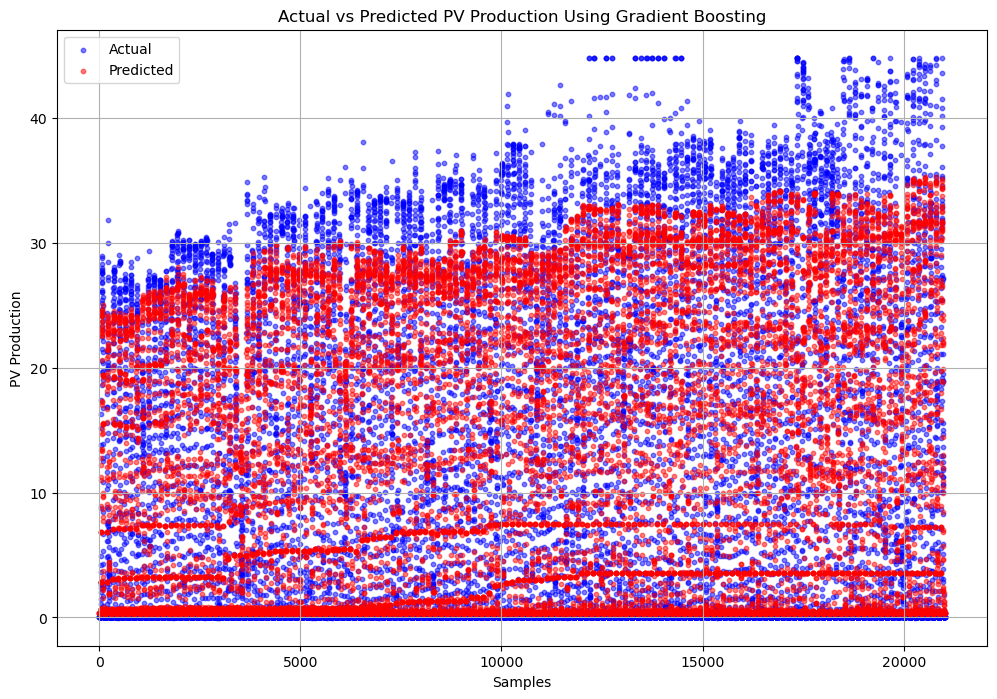

24-Hour Prediction - MSE: 16.634, RMSE: 4.078, R-squared: 0.899


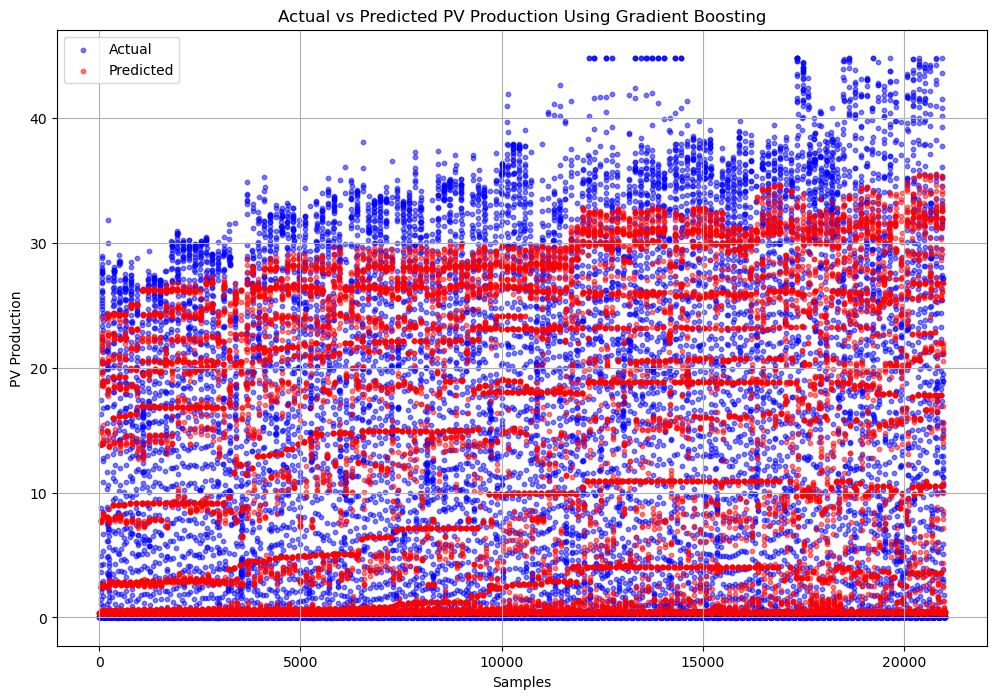

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import sqlite3
import matplotlib.pyplot as plt

# Establishing the database connection
conn = sqlite3.connect('pv_meteo_data.db') 

# Queries for each building
queries = {
     "ENERPOS_PV": "SELECT datetime, Prod_kW, GHI, BNI, DHI, DBT, RH, Ws10, Wd10, Patmo, Rainfall FROM ENERPOS_PV_Meteo",
     
}

# Fetching and combining data
frames = []
for name, query in queries.items():
    df = pd.read_sql_query(query, conn, parse_dates=['datetime'])
    df['Building'] = name
    
    # Extract time-based features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    
    # Feature Engineering: Lagged features, cyclical time features, and additional custom features
    df['Prod_kW_shifted'] = df['Prod_kW'].shift(1).fillna(0)  # Lagged feature
    df['Prod_kW_lag2'] = df['Prod_kW'].shift(2).fillna(0)     # Additional lag
    df['Prod_kW_lag3'] = df['Prod_kW'].shift(3).fillna(0)     # More lag features
    df['Prod_kW_lag6'] = df['Prod_kW'].shift(6).fillna(0)     # Lag for 6 hours back
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)      # Cyclical feature for hour
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)      # Cyclical feature for hour
    
    df['Prod_kW_ma3'] = df['Prod_kW'].rolling(window=3).mean().fillna(0)  # Moving average
    
    frames.append(df)

data = pd.concat(frames, ignore_index=True)

# Drop datetime and building columns
data.drop(columns=['datetime', 'Building'], inplace=True)

# Define the features
features = [
    'GHI', 'BNI', 'DHI', 'DBT', 'RH', 'hour', 'day_of_week', 'month', 'day_of_year',
    'Prod_kW_shifted', 'Prod_kW_lag2', 'Prod_kW_lag3', 'Prod_kW_lag6',
    'sin_hour', 'cos_hour', 'Prod_kW_ma3'
]

# Function to train and evaluate for specific horizon with train-test split
def train_and_evaluate(data, target_shift, title):
    data['target'] = data['Prod_kW'].shift(-target_shift)  # Shift the target for prediction horizon
    data.dropna(inplace=True)  # Drop rows with missing target values

    target = data['target']
    data.drop(columns=['Prod_kW'], inplace=True)  # Drop the original target column to avoid leakage

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(data[features], target, test_size=0.2, random_state=42, shuffle=False)

    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model definition using Gradient Boosting Regressor with optimized parameters and early stopping
    model = GradientBoostingRegressor(
        n_estimators=300,  
        learning_rate=0.01,
        max_depth=5,  
        subsample=0.8,
        min_samples_split=5,  
        min_samples_leaf=2, 
        random_state=42,
        validation_fraction=0.2, 
        n_iter_no_change=10,  # Early stopping if no improvement
        tol=1e-4
    )

    # Model training with early stopping
    model.fit(X_train_scaled, y_train)

    # Model evaluation
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Calculate RMSE
    r2 = r2_score(y_test, y_pred)

    print(f'{title} - MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r2:.3f}')
    
    # Scatter plot of actual vs predicted values without linear reference line
    plt.figure(figsize=(12, 8))
    plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.5, label='Actual', s=10)
    plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predicted', s=10)
    plt.title(f'Actual vs Predicted PV Production Using Gradient Boosting')
    plt.xlabel('Samples')
    plt.ylabel('PV Production')
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate for 12-hour prediction
train_and_evaluate(data.copy(), target_shift=12, title="12-Hour Prediction")

# Evaluate for 24-hour prediction
train_and_evaluate(data.copy(), target_shift=24, title="24-Hour Prediction")

# Close database connection
conn.close()


Feature Contribution explanation

Detailed Factor Analysis:

For both weekly(Day) and monthly analyses, weather-related factors like GHI, BNI, DHI (Diffuse Horizontal Irradiance), and Relative Humidity (RH) were found to be the most impactful.
These factors, together with the specific time of year, play a crucial role in shaping the PV production landscape, underscoring the importance of incorporating meteorological data into PV output forecasting models.

--- Monday ---
Average Predicted Production: 8.15 kW
Top 5 factors contributing to production on Monday (in %):
GHI            29.575514
BNI            26.935419
day_of_year    23.119081
DHI            10.841643
RH              9.528343
dtype: float64


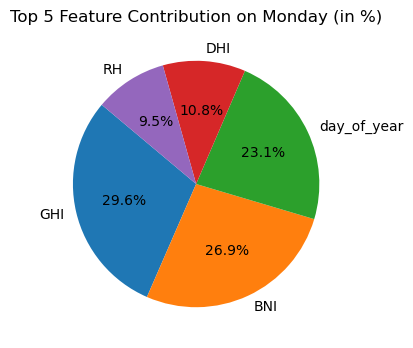

--- Tuesday ---
Average Predicted Production: 8.24 kW
Top 5 factors contributing to production on Tuesday (in %):
GHI            29.414139
BNI            27.803620
day_of_year    23.001032
DHI            10.485525
RH              9.295684
dtype: float64


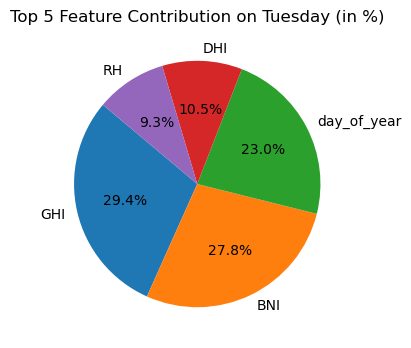

--- Wednesday ---
Average Predicted Production: 8.21 kW
Top 5 factors contributing to production on Wednesday (in %):
GHI            29.478721
BNI            27.759247
day_of_year    23.100839
DHI            10.314858
RH              9.346335
dtype: float64


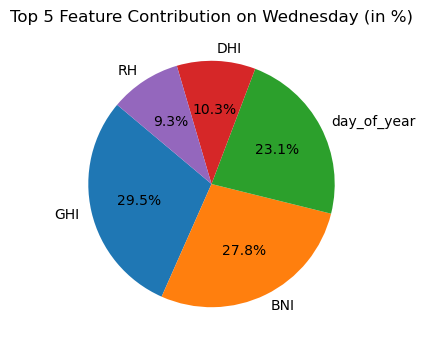

--- Thursday ---
Average Predicted Production: 8.28 kW
Top 5 factors contributing to production on Thursday (in %):
GHI            29.668626
BNI            28.686455
day_of_year    22.797830
DHI             9.725487
RH              9.121603
dtype: float64


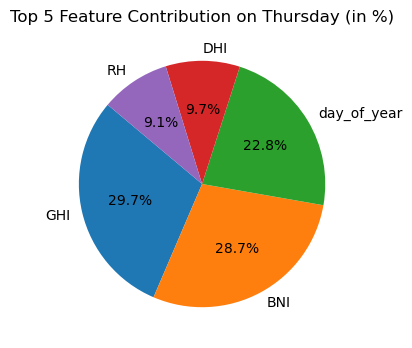

--- Friday ---
Average Predicted Production: 8.29 kW
Top 5 factors contributing to production on Friday (in %):
GHI            29.710394
BNI            28.852115
day_of_year    22.753560
DHI             9.533421
RH              9.150510
dtype: float64


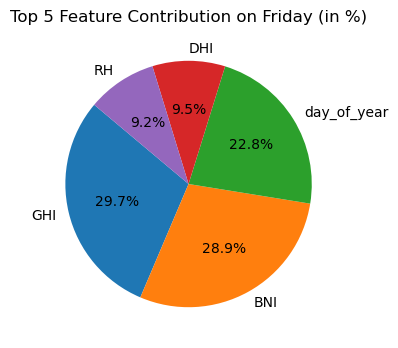

--- Saturday ---
Average Predicted Production: 8.33 kW
Top 5 factors contributing to production on Saturday (in %):
GHI            29.719784
BNI            28.211856
day_of_year    22.679068
DHI            10.139354
RH              9.249938
dtype: float64


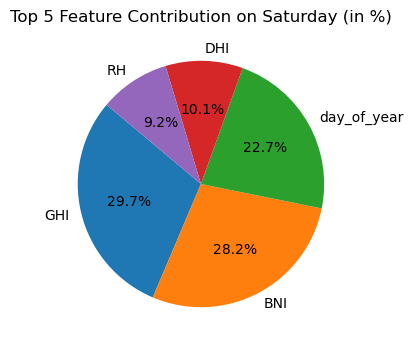

--- Sunday ---
Average Predicted Production: 8.20 kW
Top 5 factors contributing to production on Sunday (in %):
GHI            29.802428
BNI            27.674099
day_of_year    22.695058
DHI            10.515768
RH              9.312648
dtype: float64


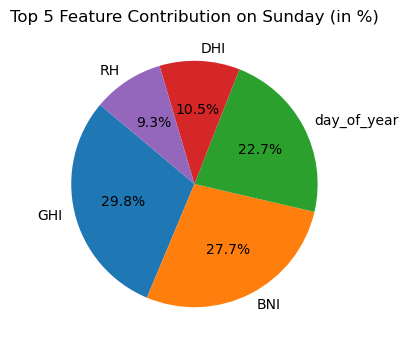

--- January ---
Average Predicted Production: 9.81 kW
Top 5 factors contributing to production in January (in %):
GHI    38.959190
BNI    33.155548
DHI    14.059620
RH     10.200799
DBT     3.624843
dtype: float64


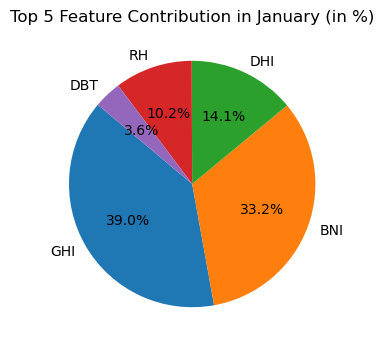

--- February ---
Average Predicted Production: 9.07 kW
Top 5 factors contributing to production in February (in %):
GHI            37.636574
BNI            31.929721
DHI            13.145538
RH             10.689182
day_of_year     6.598986
dtype: float64


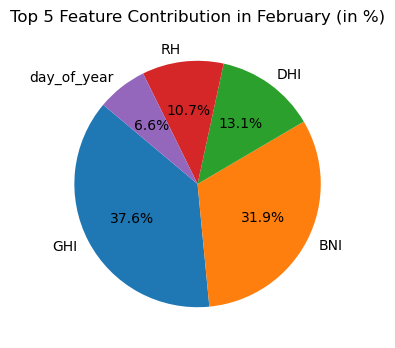

--- March ---
Average Predicted Production: 8.33 kW
Top 5 factors contributing to production in March (in %):
GHI            34.751543
BNI            30.697648
DHI            12.652566
RH             11.183887
day_of_year    10.714356
dtype: float64


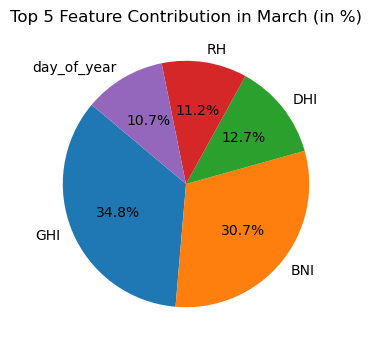

--- April ---
Average Predicted Production: 6.65 kW
Top 5 factors contributing to production in April (in %):
GHI            30.278764
BNI            26.447634
day_of_year    17.648165
RH             13.324073
DHI            12.301364
dtype: float64


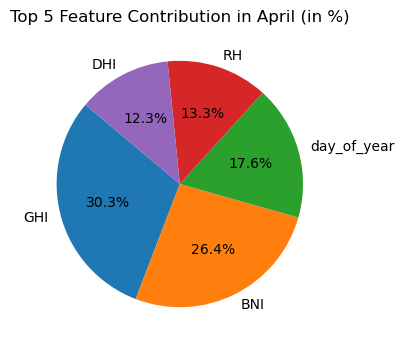

--- May ---
Average Predicted Production: 6.59 kW
Top 5 factors contributing to production in May (in %):
BNI            32.101920
GHI            27.645359
day_of_year    20.466829
RH             11.282535
DHI             8.503358
dtype: float64


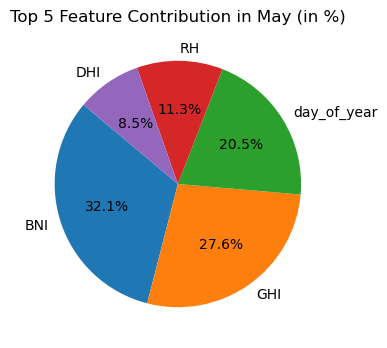

--- June ---
Average Predicted Production: 6.30 kW
Top 5 factors contributing to production in June (in %):
BNI            29.262544
day_of_year    25.514331
GHI            25.329016
RH             11.466154
DHI             8.427956
dtype: float64


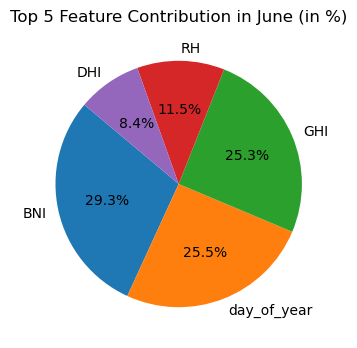

--- July ---
Average Predicted Production: 6.52 kW
Top 5 factors contributing to production in July (in %):
BNI            30.158626
day_of_year    27.224740
GHI            25.235737
RH             10.055828
DHI             7.325069
dtype: float64


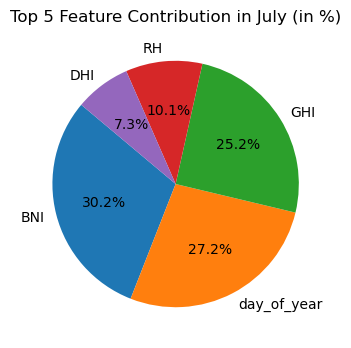

--- August ---
Average Predicted Production: 7.00 kW
Top 5 factors contributing to production in August (in %):
day_of_year    28.980855
BNI            27.168384
GHI            26.138380
RH              9.367452
DHI             8.344928
dtype: float64


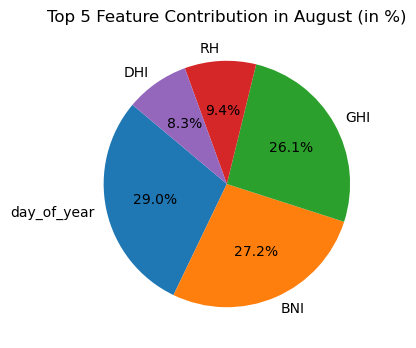

--- September ---
Average Predicted Production: 8.64 kW
Top 5 factors contributing to production in September (in %):
day_of_year    28.642577
GHI            27.902824
BNI            27.270283
DHI             8.228357
RH              7.955959
dtype: float64


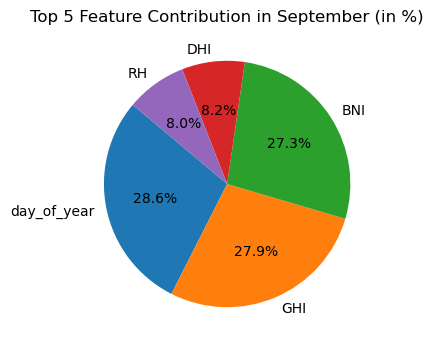

--- October ---
Average Predicted Production: 9.19 kW
Top 5 factors contributing to production in October (in %):
day_of_year    31.081378
GHI            27.709134
BNI            22.292192
DHI            11.074752
RH              7.842544
dtype: float64


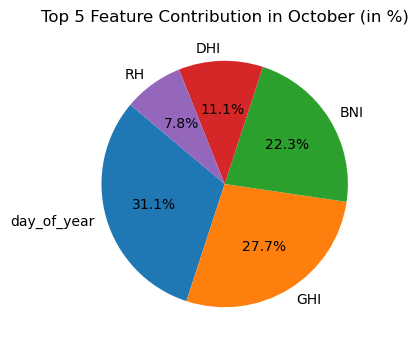

--- November ---
Average Predicted Production: 10.41 kW
Top 5 factors contributing to production in November (in %):
day_of_year    29.451020
GHI            28.578193
BNI            26.558491
DHI             8.906586
RH              6.505711
dtype: float64


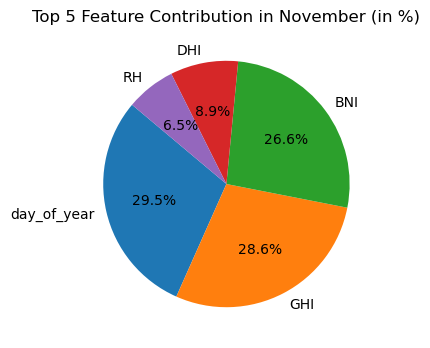

--- December ---
Average Predicted Production: 10.44 kW
Top 5 factors contributing to production in December (in %):
day_of_year    30.898595
GHI            28.033001
BNI            23.987604
DHI            10.645626
RH              6.435175
dtype: float64


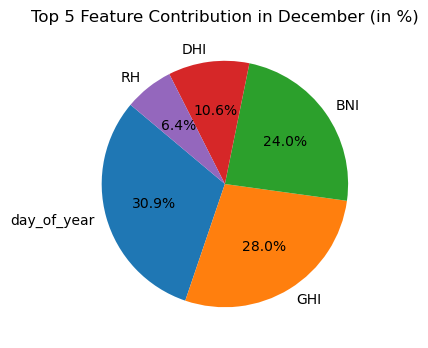

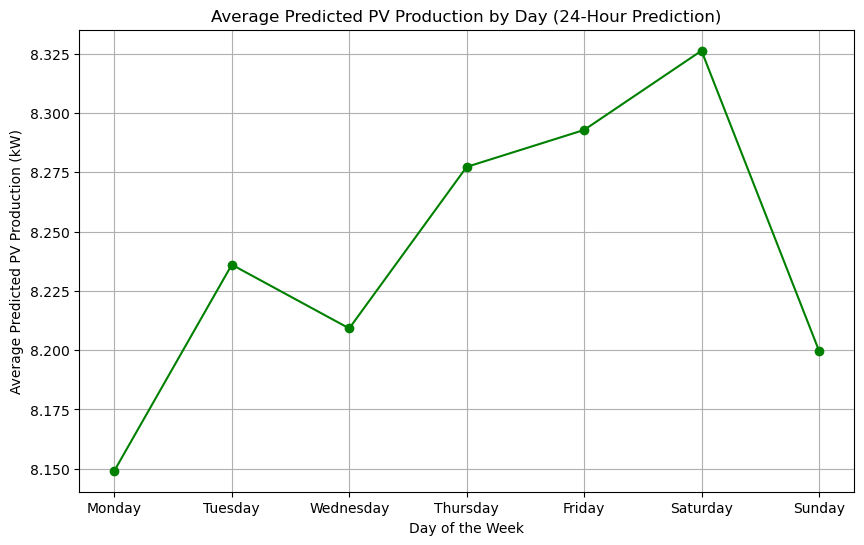

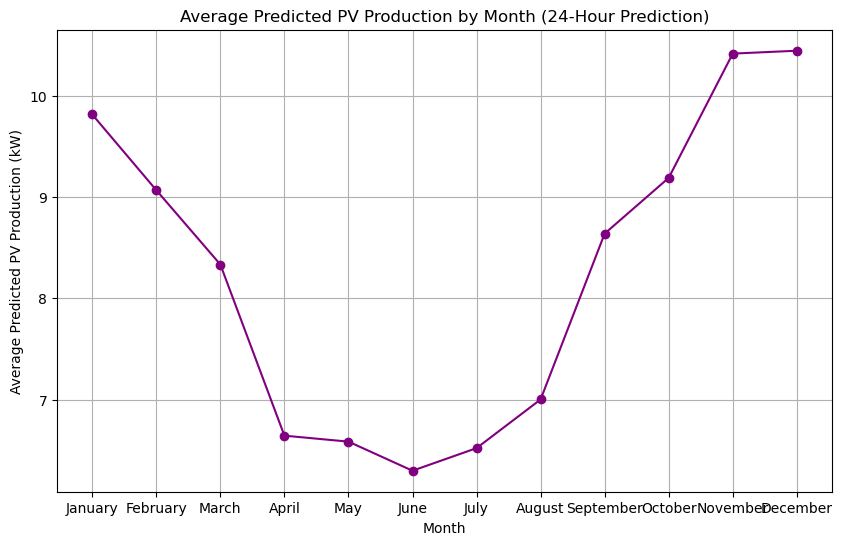

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import sqlite3
import matplotlib.pyplot as plt

# Establishing the database connection
conn = sqlite3.connect('pv_meteo_data.db')  # Adjust path if needed

# Queries for each building
queries = {
    "ENERPOS_PV": "SELECT datetime, Prod_kW, GHI, BNI, DHI, DBT, RH, Ws10, Wd10, Patmo, Rainfall FROM ENERPOS_PV_Meteo"
}

# Fetching and combining data
frames = []
for name, query in queries.items():
    df = pd.read_sql_query(query, conn, parse_dates=['datetime'])
    df['Building'] = name
    
    # Extract time-based features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    
    # Feature Engineering: Lagged features, cyclical time features, and additional custom features
    df['Prod_kW_shifted'] = df['Prod_kW'].shift(1).fillna(0)  # Lagged feature
    df['Prod_kW_lag2'] = df['Prod_kW'].shift(2).fillna(0)     # Additional lag
    df['Prod_kW_lag3'] = df['Prod_kW'].shift(3).fillna(0)     # More lag features
    df['Prod_kW_lag6'] = df['Prod_kW'].shift(6).fillna(0)     # Lag for 6 hours back
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)      # Cyclical feature for hour
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)      # Cyclical feature for hour
    
 
    df['Prod_kW_ma3'] = df['Prod_kW'].rolling(window=3).mean().fillna(0)  # Moving average
    
    frames.append(df)

data = pd.concat(frames, ignore_index=True)

# Drop datetime and building columns
data.drop(columns=['datetime', 'Building'], inplace=True)

# Define the features
features = [
    'GHI', 'BNI', 'DHI', 'DBT', 'RH', 'hour', 'day_of_week', 'month', 'day_of_year',
    'Prod_kW_shifted', 'Prod_kW_lag2', 'Prod_kW_lag3', 'Prod_kW_lag6',
    'sin_hour', 'cos_hour', 'Prod_kW_ma3'
]

# Function to train and evaluate for specific horizon with train-test split
def train_and_evaluate(data, target_shift, title):
    data['target'] = data['Prod_kW'].shift(-target_shift)  # Shift the target for prediction horizon
    data.dropna(inplace=True)  # Drop rows with missing target values

    target = data['target']
    data.drop(columns=['Prod_kW'], inplace=True)  # Drop the original target column to avoid leakage

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(data[features], target, test_size=0.2, random_state=42, shuffle=False)

    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model definition using Gradient Boosting Regressor with optimized parameters and early stopping
    model = GradientBoostingRegressor(
        n_estimators=300,  # Increased number of trees for more learning opportunities
        learning_rate=0.01,
        max_depth=5,  # Increased complexity to handle more detailed patterns
        subsample=0.8,
        min_samples_split=5,  # Reduced split threshold for better learning
        min_samples_leaf=2,  # Reduced leaf size for more detailed splits
        random_state=42,
        validation_fraction=0.2,  # Fraction of training data for validation
        n_iter_no_change=10,  # Early stopping if no improvement
        tol=1e-4
    )

    # Model training with early stopping
    model.fit(X_train_scaled, y_train)

    # Predictions
    data['Predicted_Prod_kW'] = model.predict(scaler.transform(data[features]))

    ### Analyze the contribution for each day of the week
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    avg_daily_production = {}

    for i, day in enumerate(days_of_week):
        day_data = data[data['day_of_week'] == i]
        avg_prod = day_data['Predicted_Prod_kW'].mean()
        avg_features = day_data[features].mean()
        avg_daily_production[days_of_week[i]] = avg_prod  # Store for line graph

        print(f"--- {days_of_week[i]} ---")
        print(f"Average Predicted Production: {avg_prod:.2f} kW")
        
        # Sort features by their contribution and select top 5
        top_features = avg_features.sort_values(ascending=False).head(5)
        total_value = top_features.sum()
        top_features_percent = (top_features / total_value) * 100
        
        print(f"Top 5 factors contributing to production on {days_of_week[i]} (in %):")
        print(top_features_percent)
        
        # Create a pie chart for the top 5 factors for that day
        plt.figure(figsize=(4, 4))
        plt.pie(top_features_percent, labels=top_features_percent.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        plt.title(f"Top 5 Feature Contribution on {days_of_week[i]} (in %)")
        plt.show()

    ### Analyze the contribution for each month
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    avg_monthly_production = {}

    for i, month in enumerate(range(1, 13)):
        month_data = data[data['month'] == month]
        avg_prod = month_data['Predicted_Prod_kW'].mean()
        avg_features = month_data[features].mean()
        avg_monthly_production[months[i]] = avg_prod  # Store for line graph

        print(f"--- {months[i]} ---")
        print(f"Average Predicted Production: {avg_prod:.2f} kW")
        
        # Sort features by their contribution and select top 5
        top_features = avg_features.sort_values(ascending=False).head(5)
        total_value = top_features.sum()
        top_features_percent = (top_features / total_value) * 100
        
        print(f"Top 5 factors contributing to production in {months[i]} (in %):")
        print(top_features_percent)
        
        # Create a pie chart for the top 5 factors for that month
        plt.figure(figsize=(4, 4))
        plt.pie(top_features_percent, labels=top_features_percent.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        plt.title(f"Top 5 Feature Contribution in {months[i]} (in %)")
        plt.show()

    ### Line Graphs ###
    # Generate line graph for average predicted PV production by day
    plt.figure(figsize=(10, 6))
    plt.plot(list(avg_daily_production.keys()), list(avg_daily_production.values()), marker='o', color='green')
    plt.title('Average Predicted PV Production by Day (24-Hour Prediction)')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Predicted PV Production (kW)')
    plt.grid(True)
    plt.show()

    # Generate line graph for average predicted PV production by month
    plt.figure(figsize=(10, 6))
    plt.plot(list(avg_monthly_production.keys()), list(avg_monthly_production.values()), marker='o', color='purple')
    plt.title('Average Predicted PV Production by Month (24-Hour Prediction)')
    plt.xlabel('Month')
    plt.ylabel('Average Predicted PV Production (kW)')
    plt.grid(True)
    plt.show()

# Evaluate for 24-hour prediction
train_and_evaluate(data.copy(), target_shift=24, title="24-Hour Prediction - ENEROPOS_PV")

# Close database connection

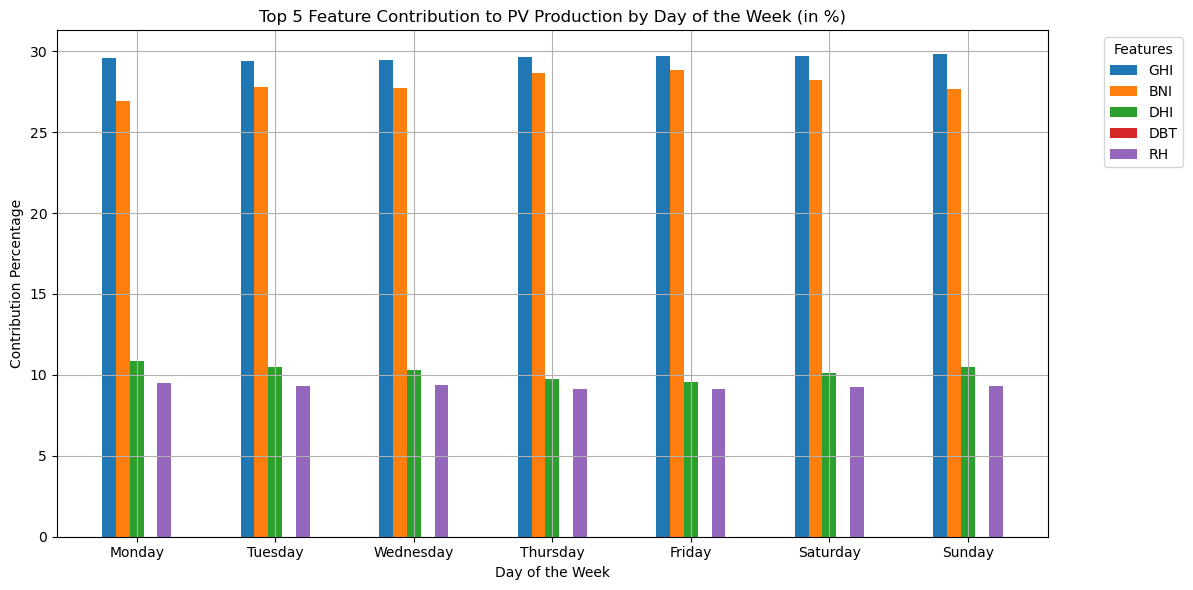

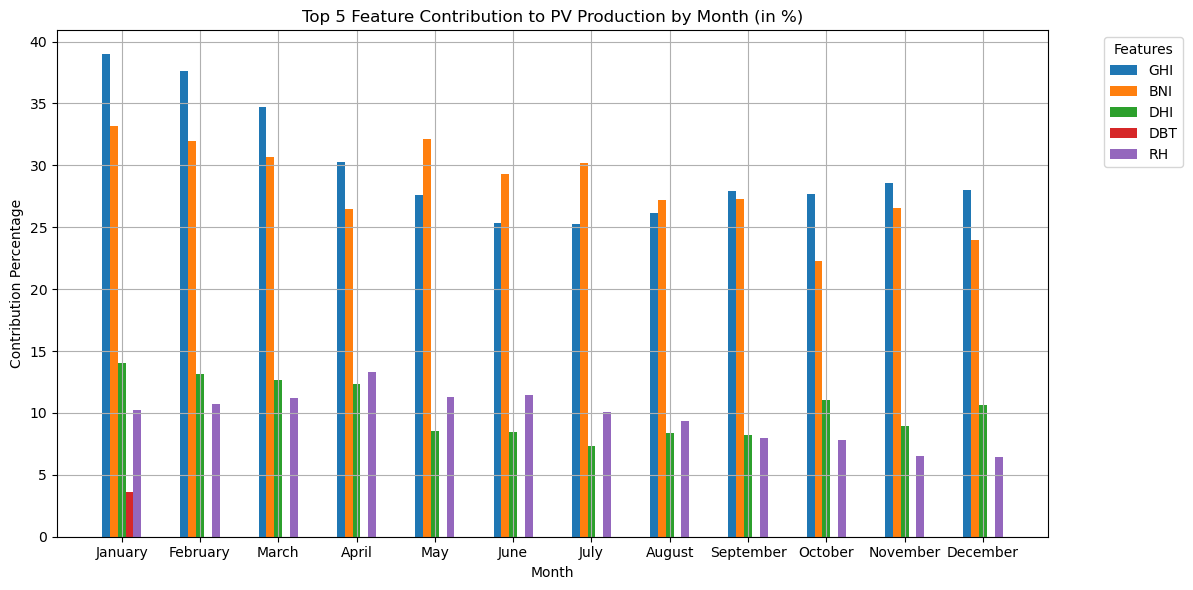

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import sqlite3
import matplotlib.pyplot as plt

# Function to plot side-by-side bar graph
def plot_grouped_bar(df, x_labels, title, x_label):
    num_features = len(df.index)
    num_groups = len(df.columns)
    bar_width = 0.1  # Width of individual bars
    x = np.arange(num_groups)  # The label locations
    
    # Create a figure
    plt.figure(figsize=(12, 6))
    
    # Plot each feature as a separate set of bars
    for i, feature in enumerate(df.index):
        plt.bar(x + i * bar_width, df.loc[feature], width=bar_width, label=feature)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Contribution Percentage')
    plt.xticks(x + bar_width * (num_features - 1) / 2, x_labels)  # Position the ticks in the middle of the groups
    plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Establishing the database connection
conn = sqlite3.connect('pv_meteo_data.db')  # Adjust path if needed

# Queries for each building
queries = {
    "ENERPOS_PV": "SELECT datetime, Prod_kW, GHI, BNI, DHI, DBT, RH, Ws10, Wd10, Patmo, Rainfall FROM ENERPOS_PV_Meteo"
}

# Fetching and combining data
frames = []
for name, query in queries.items():
    df = pd.read_sql_query(query, conn, parse_dates=['datetime'])
    df['Building'] = name
    
    # Extract time-based features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    
    # Feature Engineering: Lagged features, cyclical time features, and additional custom features
    df['Prod_kW_shifted'] = df['Prod_kW'].shift(1).fillna(0)  # Lagged feature
    df['Prod_kW_lag2'] = df['Prod_kW'].shift(2).fillna(0)     # Additional lag
    df['Prod_kW_lag3'] = df['Prod_kW'].shift(3).fillna(0)     # More lag features
    df['Prod_kW_lag6'] = df['Prod_kW'].shift(6).fillna(0)     # Lag for 6 hours back
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)      # Cyclical feature for hour
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)      # Cyclical feature for hour
    
    # Rolling feature
    df['Prod_kW_ma3'] = df['Prod_kW'].rolling(window=3).mean().fillna(0)  # Moving average
    
    frames.append(df)

data = pd.concat(frames, ignore_index=True)

# Drop datetime and building columns
data.drop(columns=['datetime', 'Building'], inplace=True)

# Define the features
features = [
    'GHI', 'BNI', 'DHI', 'DBT', 'RH', 'hour', 'day_of_week', 'month', 'day_of_year',
    'Prod_kW_shifted', 'Prod_kW_lag2', 'Prod_kW_lag3', 'Prod_kW_lag6',
    'sin_hour', 'cos_hour', 'Prod_kW_ma3'
]

# Function to train and evaluate for 24-hour prediction and generate grouped bar charts
def train_and_evaluate_with_grouped_bars(data, target_shift, title):
    data['target'] = data['Prod_kW'].shift(-target_shift)  # Shift the target for prediction horizon
    data.dropna(inplace=True)  # Drop rows with missing target values

    target = data['target']
    data.drop(columns=['Prod_kW'], inplace=True)  # Drop the original target column to avoid leakage

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(data[features], target, test_size=0.2, random_state=42, shuffle=False)

    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model definition using Gradient Boosting Regressor with optimized parameters and early stopping
    model = GradientBoostingRegressor(
        n_estimators=300,  # Increased number of trees for more learning opportunities
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        validation_fraction=0.2,
        n_iter_no_change=10,
        tol=1e-4
    )

    # Model training with early stopping
    model.fit(X_train_scaled, y_train)

    # Predictions
    data['Predicted_Prod_kW'] = model.predict(scaler.transform(data[features]))

    ### Analyze the contribution for each day of the week
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    feature_contributions_daily = pd.DataFrame(index=features[:5])  # Top 5 features

    for i, day in enumerate(days_of_week):
        day_data = data[data['day_of_week'] == i]
        avg_features = day_data[features].mean()

        # Sort features by their contribution and select top 5
        top_features = avg_features.sort_values(ascending=False).head(5)
        total_value = top_features.sum()
        top_features_percent = (top_features / total_value) * 100
        
        feature_contributions_daily[day] = top_features_percent

    ### Analyze the contribution for each month
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    feature_contributions_monthly = pd.DataFrame(index=features[:5])  # Top 5 features

    for i, month in enumerate(range(1, 13)):
        month_data = data[data['month'] == month]
        avg_features = month_data[features].mean()

        # Sort features by their contribution and select top 5
        top_features = avg_features.sort_values(ascending=False).head(5)
        total_value = top_features.sum()
        top_features_percent = (top_features / total_value) * 100
        
        feature_contributions_monthly[months[i]] = top_features_percent

    ### Grouped Bar Graphs ###
    # Generate grouped bar graph for feature contribution by day
    plot_grouped_bar(feature_contributions_daily, days_of_week, 
                     'Top 5 Feature Contribution to PV Production by Day of the Week (in %)', 
                     'Day of the Week')

    # Generate grouped bar graph for feature contribution by month
    plot_grouped_bar(feature_contributions_monthly, months, 
                     'Top 5 Feature Contribution to PV Production by Month (in %)', 
                     'Month')

# Evaluate for 24-hour prediction with grouped bar graphs
train_and_evaluate_with_grouped_bars(data.copy(), target_shift=24, title="24-Hour Prediction - ENERPOS_PV")

# Close the database connection
conn.close()
